In [1]:
import os
from pathlib import Path

from es_sfgtools.processing.pipeline.data_handler import DataHandler
from es_sfgtools.processing.assets.siteconfig import SiteConfig, Site
from es_sfgtools.processing.operations.site_ops import (
    CTDfile_to_svp,
    masterfile_to_siteconfig,
    leverarmfile_to_atdoffset,
)
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [32,18]
from es_sfgtools.utils.loggers import BaseLogger
pride_path = Path.home() / ".PRIDE_PPPAR_BIN"
os.environ["PATH"] += os.pathsep + str(pride_path)

In [9]:
main_dir = Path("/Users/franklyndunbar/Project/SeaFloorGeodesy/Data/SFGMain")
dh = DataHandler(main_dir)
OVERRIDE=False
RES_FILTER = 25
network = "cascadia-gorda"
station = "NCC1"
survey = "2024_A_1126"

dh.change_working_station(network=network, station=station, survey=survey)
ncc1_2024_config = dh.station_dir / "NCC1_2024_config.yaml"
svp_path = dh.station_dir / "NCC1_CTD_2021_fit"
svp_path_processed = dh.station_dir / "svp.csv"
if not svp_path_processed.exists():
    svp_df = CTDfile_to_svp(svp_path)
    svp_df.to_csv(svp_path_processed)

config = SiteConfig.from_config(ncc1_2024_config)
config.sound_speed_data = svp_path_processed
gp_handler_ncc1= dh.get_garpos_handler(site_config=config)


In [11]:
site_path = Path(
    "/Users/franklyndunbar/Project/SeaFloorGeodesy/es_sfgtools/dev/NCC1_Dec3_move_around.json"
)

gp_handler_ncc1.load_campaign_data(site_path)
gp_handler_ncc1.set_campaign("2024_A_1126")
update_dict = {"rejectcriteria": 2.5,"log_lambda":[0]}
gp_handler_ncc1.set_inversion_params(update_dict)
for survey in list(gp_handler_ncc1.campaign.surveys.values()):
    print(survey)

id='2024_A_1126_1' type='circle drive' vesselName='1126' benchmarkIDs=['NCC1-1', 'NCC1-2', 'NCC1-3'] start=datetime.datetime(2024, 9, 22, 17, 30) end=datetime.datetime(2024, 9, 23, 0, 35) shot_data_path=None
id='2024_A_1126_2' type='center' vesselName='1126' benchmarkIDs=['NCC1-1', 'NCC1-2', 'NCC1-3-2'] start=datetime.datetime(2024, 9, 26, 15, 30) end=datetime.datetime(2024, 10, 8, 15, 0) shot_data_path=None
id='2024_A_1126_3' type='move around' vesselName='1126' benchmarkIDs=['NCC1-1', 'NCC1-2', 'NCC1-3-2'] start=datetime.datetime(2024, 10, 8, 16, 0) end=datetime.datetime(2024, 10, 11, 2, 0) shot_data_path=None
id='2024_A_1126_4' type='move around' vesselName='1126' benchmarkIDs=['NCC1-1', 'NCC1-2', 'NCC1-3-2'] start=datetime.datetime(2024, 10, 11, 2, 30) end=datetime.datetime(2024, 10, 13, 0, 16) shot_data_path=None
id='2024_A_1126_5' type='move around' vesselName='1126' benchmarkIDs=['NCC1-1', 'NCC1-2', 'NCC1-3-2'] start=datetime.datetime(2024, 10, 13, 0, 16) end=datetime.datetime(2

In [16]:
gp_handler_ncc1.prep_shotdata(overwrite=OVERRIDE)
update_dict = {"rejectcriteria": 2.5}
gp_handler_ncc1.set_inversion_params(update_dict)

In [5]:
gp_handler_ncc1.run_garpos(survey_id='2024_A_1126_1',override=OVERRIDE)

Running GARPOS for /Users/franklyndunbar/Project/SeaFloorGeodesy/Data/SFGMain/cascadia-gorda/NCC1/GARPOS/shotdata/2024_A_1126_1_circledrive_266_267.csv
       suffix  lamb0  lgrad  mu_t  mu_m
0  Cascadia_0    1.0    0.1   0.0   0.5
Inversion loop 001, RMS(TT) =  29.523536 ms, used_shot =  95.1%, reject =  227, Max(dX) =    10.0000, Hgt =   -982.693
Inversion loop 002, RMS(TT) =  28.375784 ms, used_shot =  93.6%, reject =  300, Max(dX) =    10.0000, Hgt =   -982.693
Inversion loop 003, RMS(TT) =  27.215106 ms, used_shot =  93.2%, reject =  315, Max(dX) =    10.0000, Hgt =   -982.693
Inversion loop 004, RMS(TT) =  26.058317 ms, used_shot =  93.2%, reject =  317, Max(dX) =    10.0000, Hgt =   -982.693
Inversion loop 005, RMS(TT) =  24.888718 ms, used_shot =  93.0%, reject =  327, Max(dX) =    10.0000, Hgt =   -982.693
Inversion loop 006, RMS(TT) =  23.723316 ms, used_shot =  92.7%, reject =  338, Max(dX) =    10.0000, Hgt =   -982.693
Inversion loop 007, RMS(TT) =  22.564607 ms, used_shot

Plotting results for survey  2024_A_1126_1
Delta Center Position
Array :  East 1.606 m, North 9.127 m, Up 0.000 m 
TSP M5209 : East 0.442 m, North -0.084 m, Up -0.088 m 
TSP M5210 : East 0.471 m, North -0.070 m, Up -0.118 m 
TSP M5211 : East 0.482 m, North -0.065 m, Up -0.087 m 



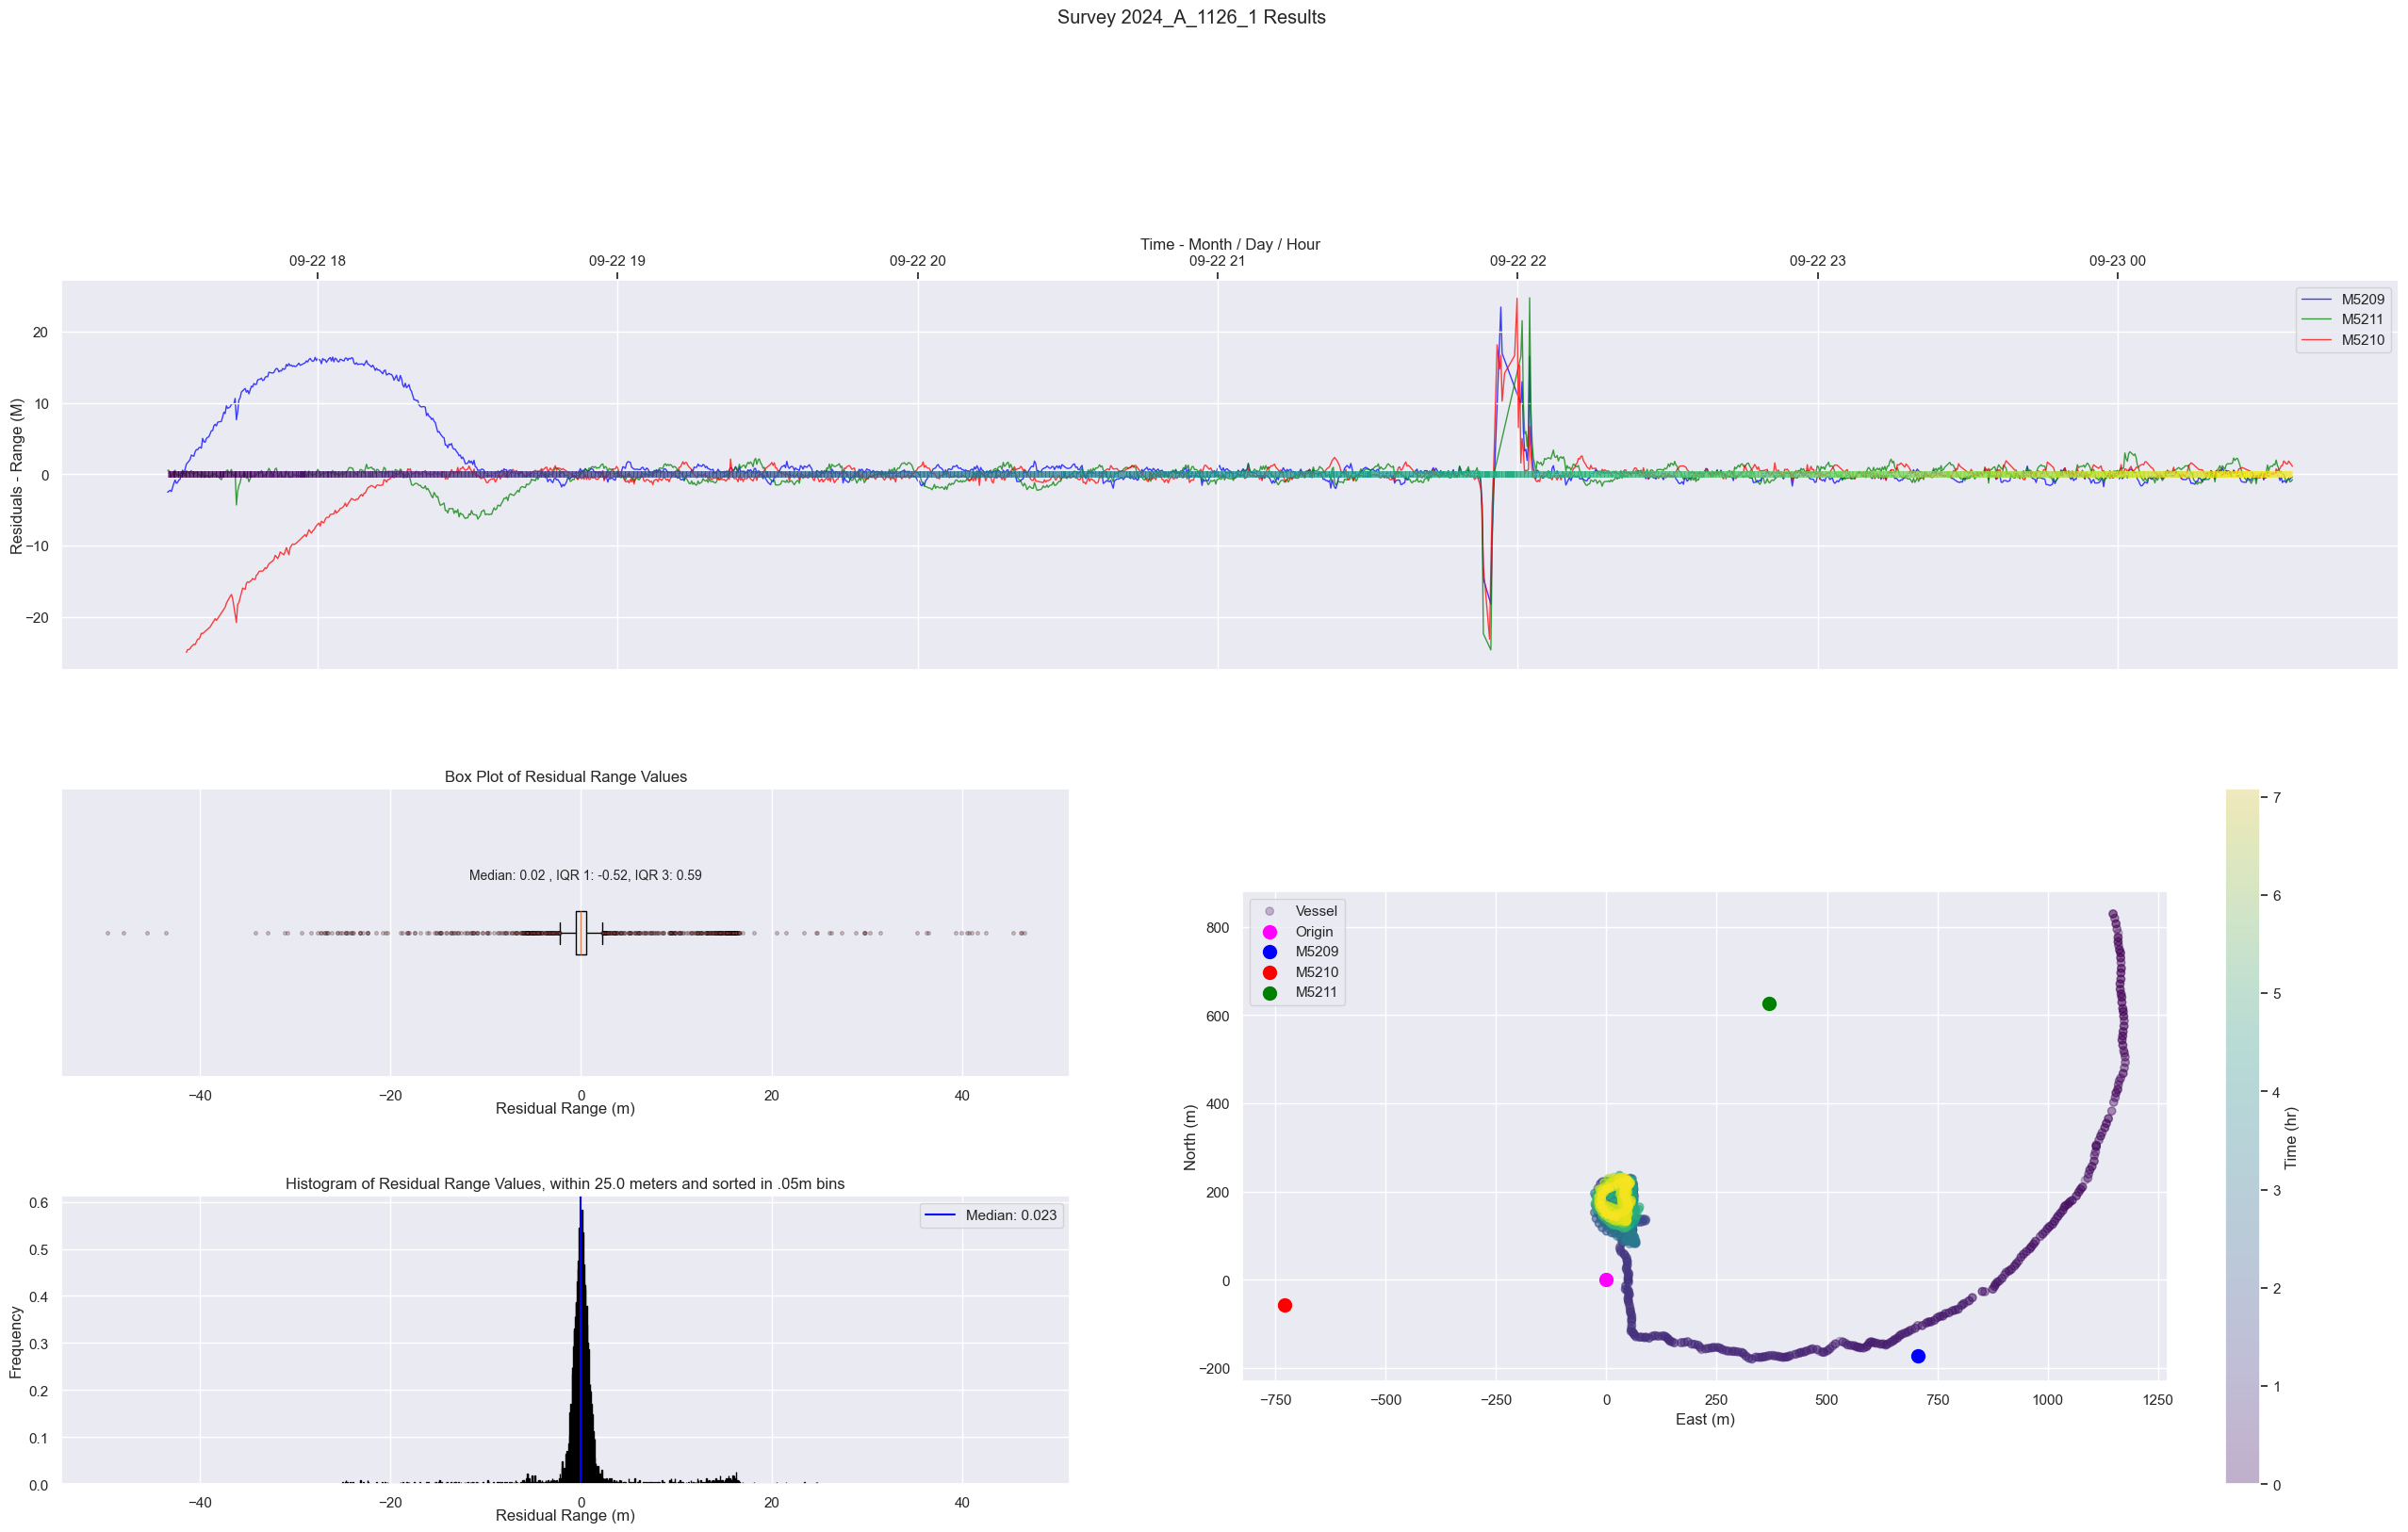

In [6]:
gp_handler_ncc1.plot_ts_results('2024_A_1126_1',res_filter=RES_FILTER)

In [7]:
gp_handler_ncc1.run_garpos(survey_id="2024_A_1126_2", override=OVERRIDE)

Running GARPOS for /Users/franklyndunbar/Project/SeaFloorGeodesy/Data/SFGMain/cascadia-gorda/NCC1/GARPOS/shotdata/2024_A_1126_2_center_270_282.csv
       suffix  lamb0  lgrad  mu_t  mu_m
0  Cascadia_0    1.0    0.1   0.0   0.5
Inversion loop 001, RMS(TT) =  29.673279 ms, used_shot =  97.2%, reject = 3177, Max(dX) =    10.0000, Hgt =   -982.693
Inversion loop 002, RMS(TT) =  28.660595 ms, used_shot =  96.3%, reject = 4218, Max(dX) =    10.0000, Hgt =   -982.693
Inversion loop 003, RMS(TT) =  27.634412 ms, used_shot =  96.0%, reject = 4610, Max(dX) =    10.0000, Hgt =   -982.693
Inversion loop 004, RMS(TT) =  26.621515 ms, used_shot =  95.8%, reject = 4765, Max(dX) =    10.0000, Hgt =   -982.693
Inversion loop 005, RMS(TT) =  25.609737 ms, used_shot =  95.8%, reject = 4844, Max(dX) =    10.0000, Hgt =   -982.693
Inversion loop 006, RMS(TT) =  24.598002 ms, used_shot =  95.7%, reject = 4896, Max(dX) =    10.0000, Hgt =   -982.693
Inversion loop 007, RMS(TT) =  23.585293 ms, used_shot =  9

Plotting results for survey  2024_A_1126_2
Delta Center Position
Array :  East -0.274 m, North 2.537 m, Up 0.000 m 
TSP M5209 : East 0.001 m, North 0.297 m, Up 0.383 m 
TSP M5210 : East -0.011 m, North 0.309 m, Up 0.387 m 
TSP M5211 : East -0.006 m, North 0.296 m, Up 0.387 m 



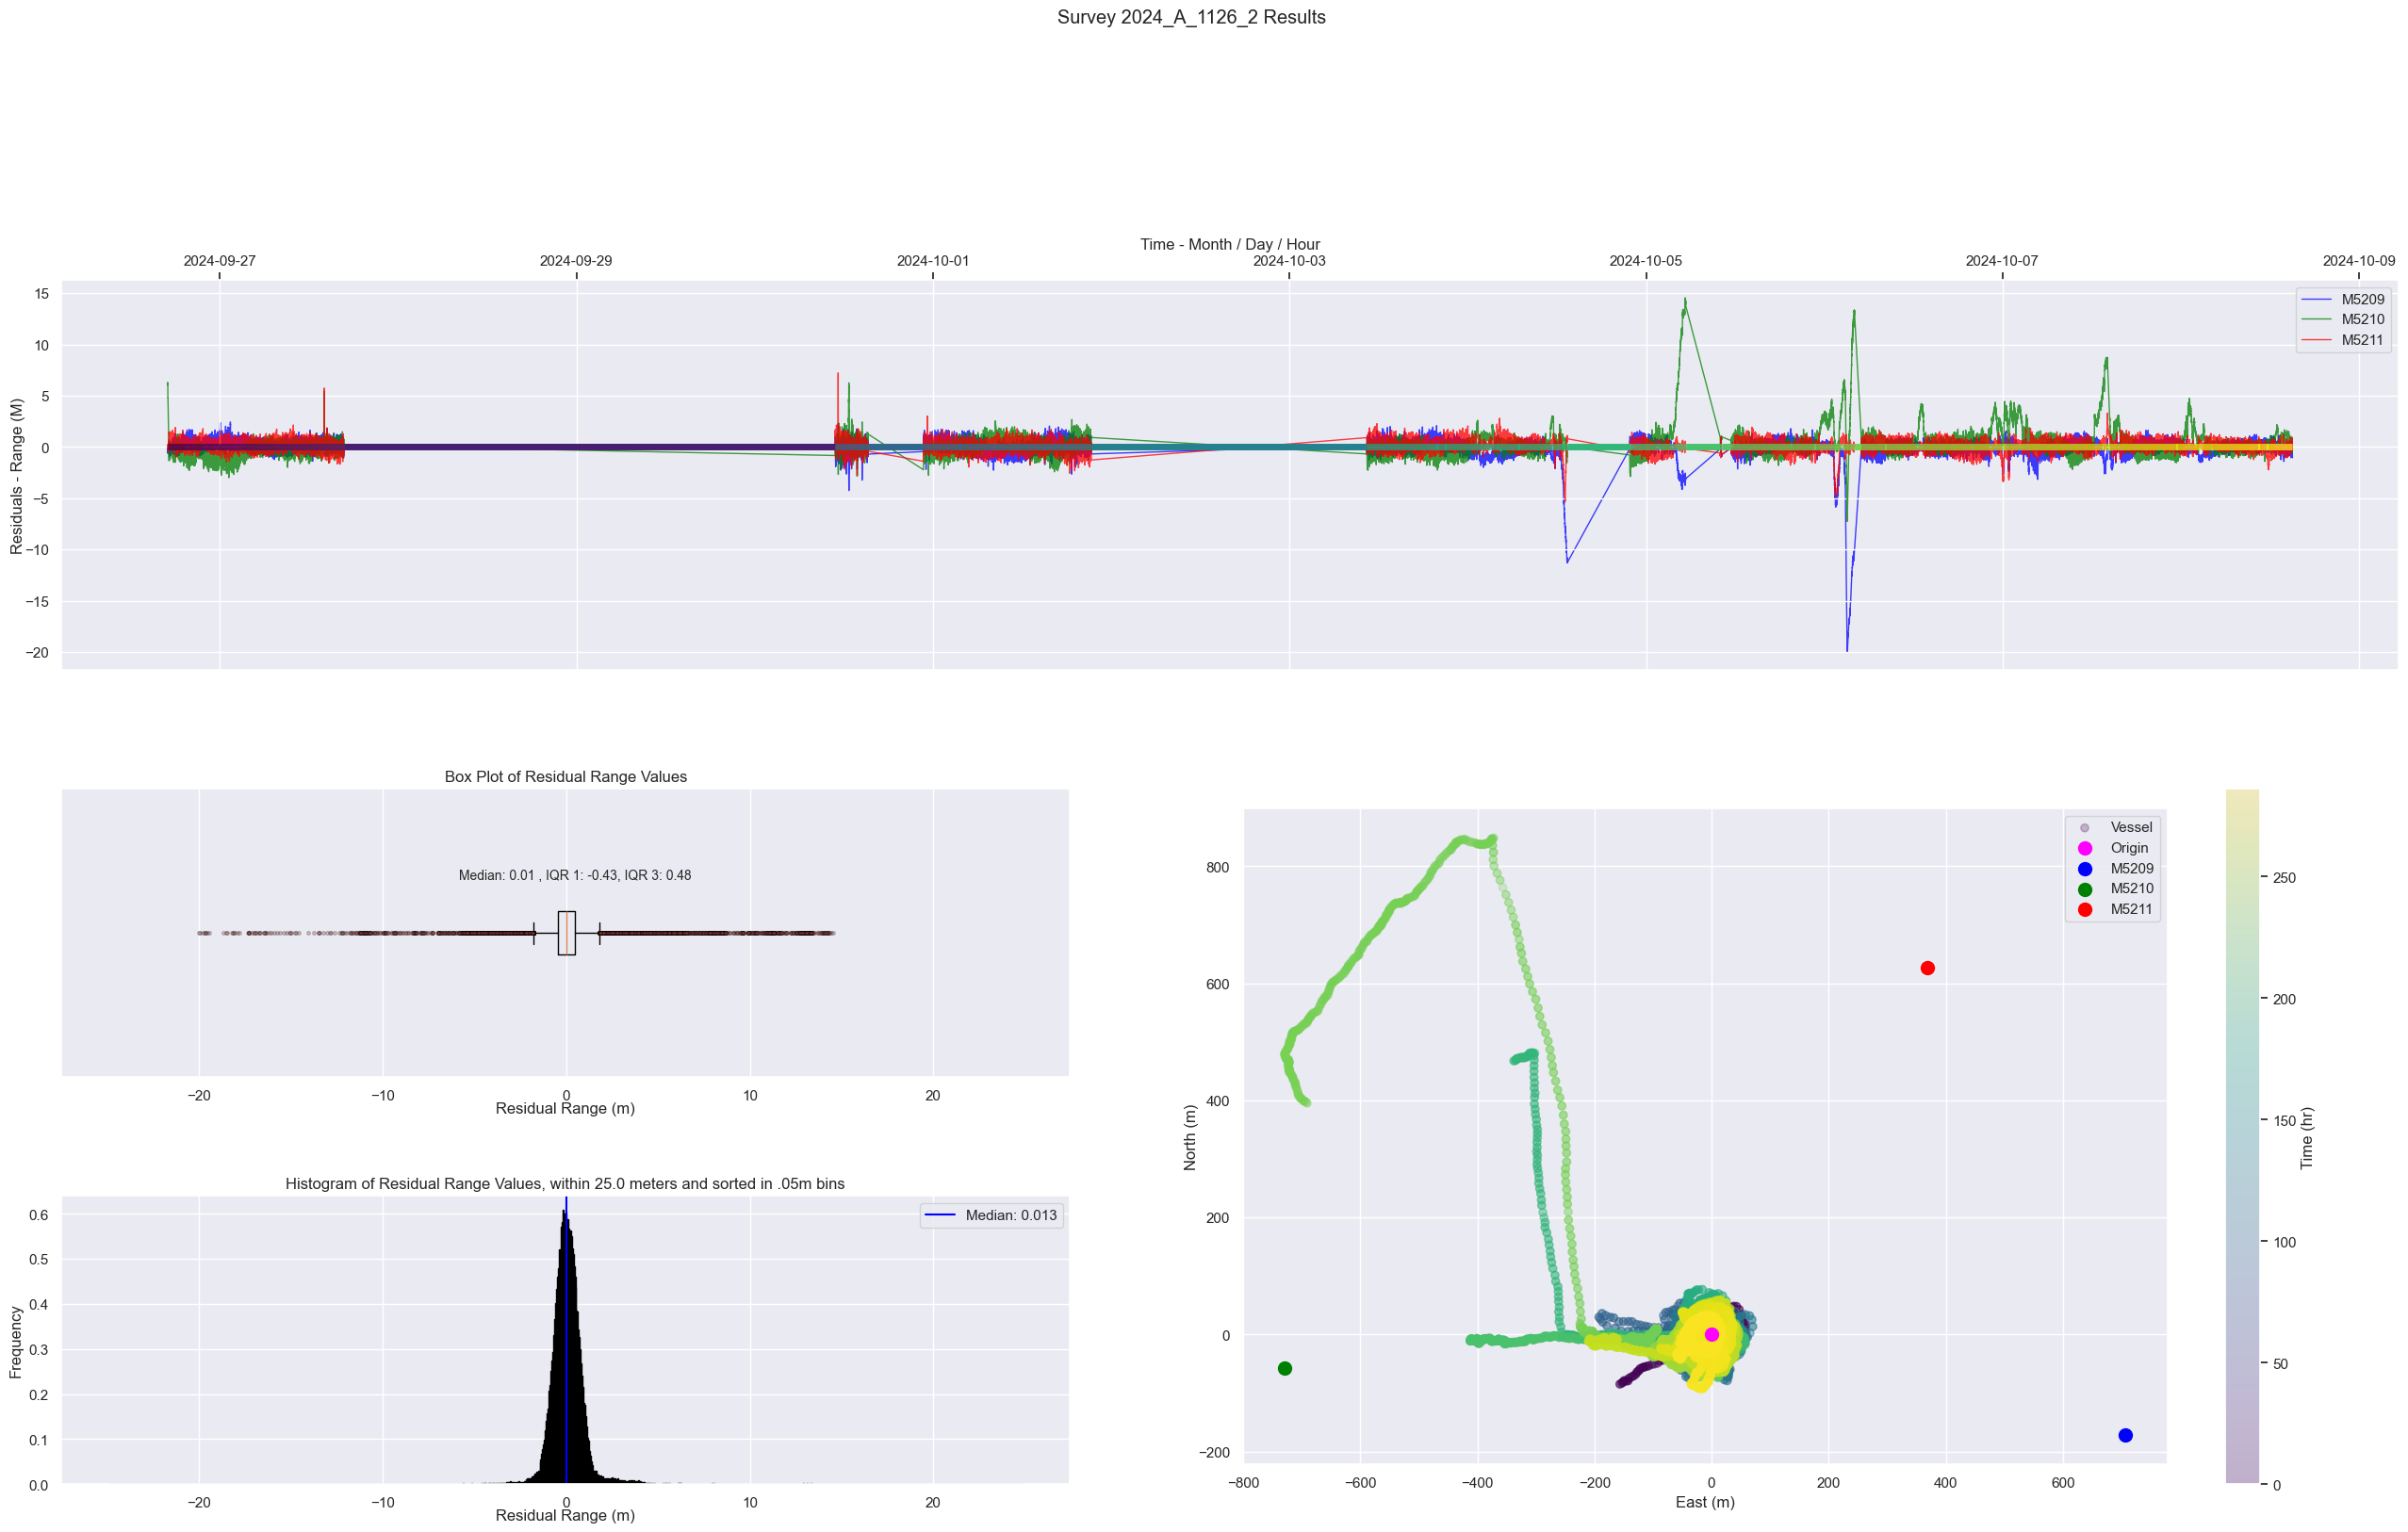

In [8]:
gp_handler_ncc1.plot_ts_results("2024_A_1126_2",res_filter=RES_FILTER)

In [17]:
gp_handler_ncc1.run_garpos(survey_id="2024_A_1126_3",override=OVERRIDE)

Results already exist for /Users/franklyndunbar/Project/SeaFloorGeodesy/Data/SFGMain/cascadia-gorda/NCC1/GARPOS/results/2024_A_1126_3/_0_results.json


Plotting results for survey  2024_A_1126_3
Delta Center Position
Array :  East 0.511 m, North 2.027 m, Up 0.000 m 
TSP M5209 : East 0.081 m, North 0.081 m, Up 0.123 m 
TSP M5210 : East 0.061 m, North 0.070 m, Up 0.080 m 
TSP M5211 : East 0.053 m, North 0.064 m, Up 0.113 m 



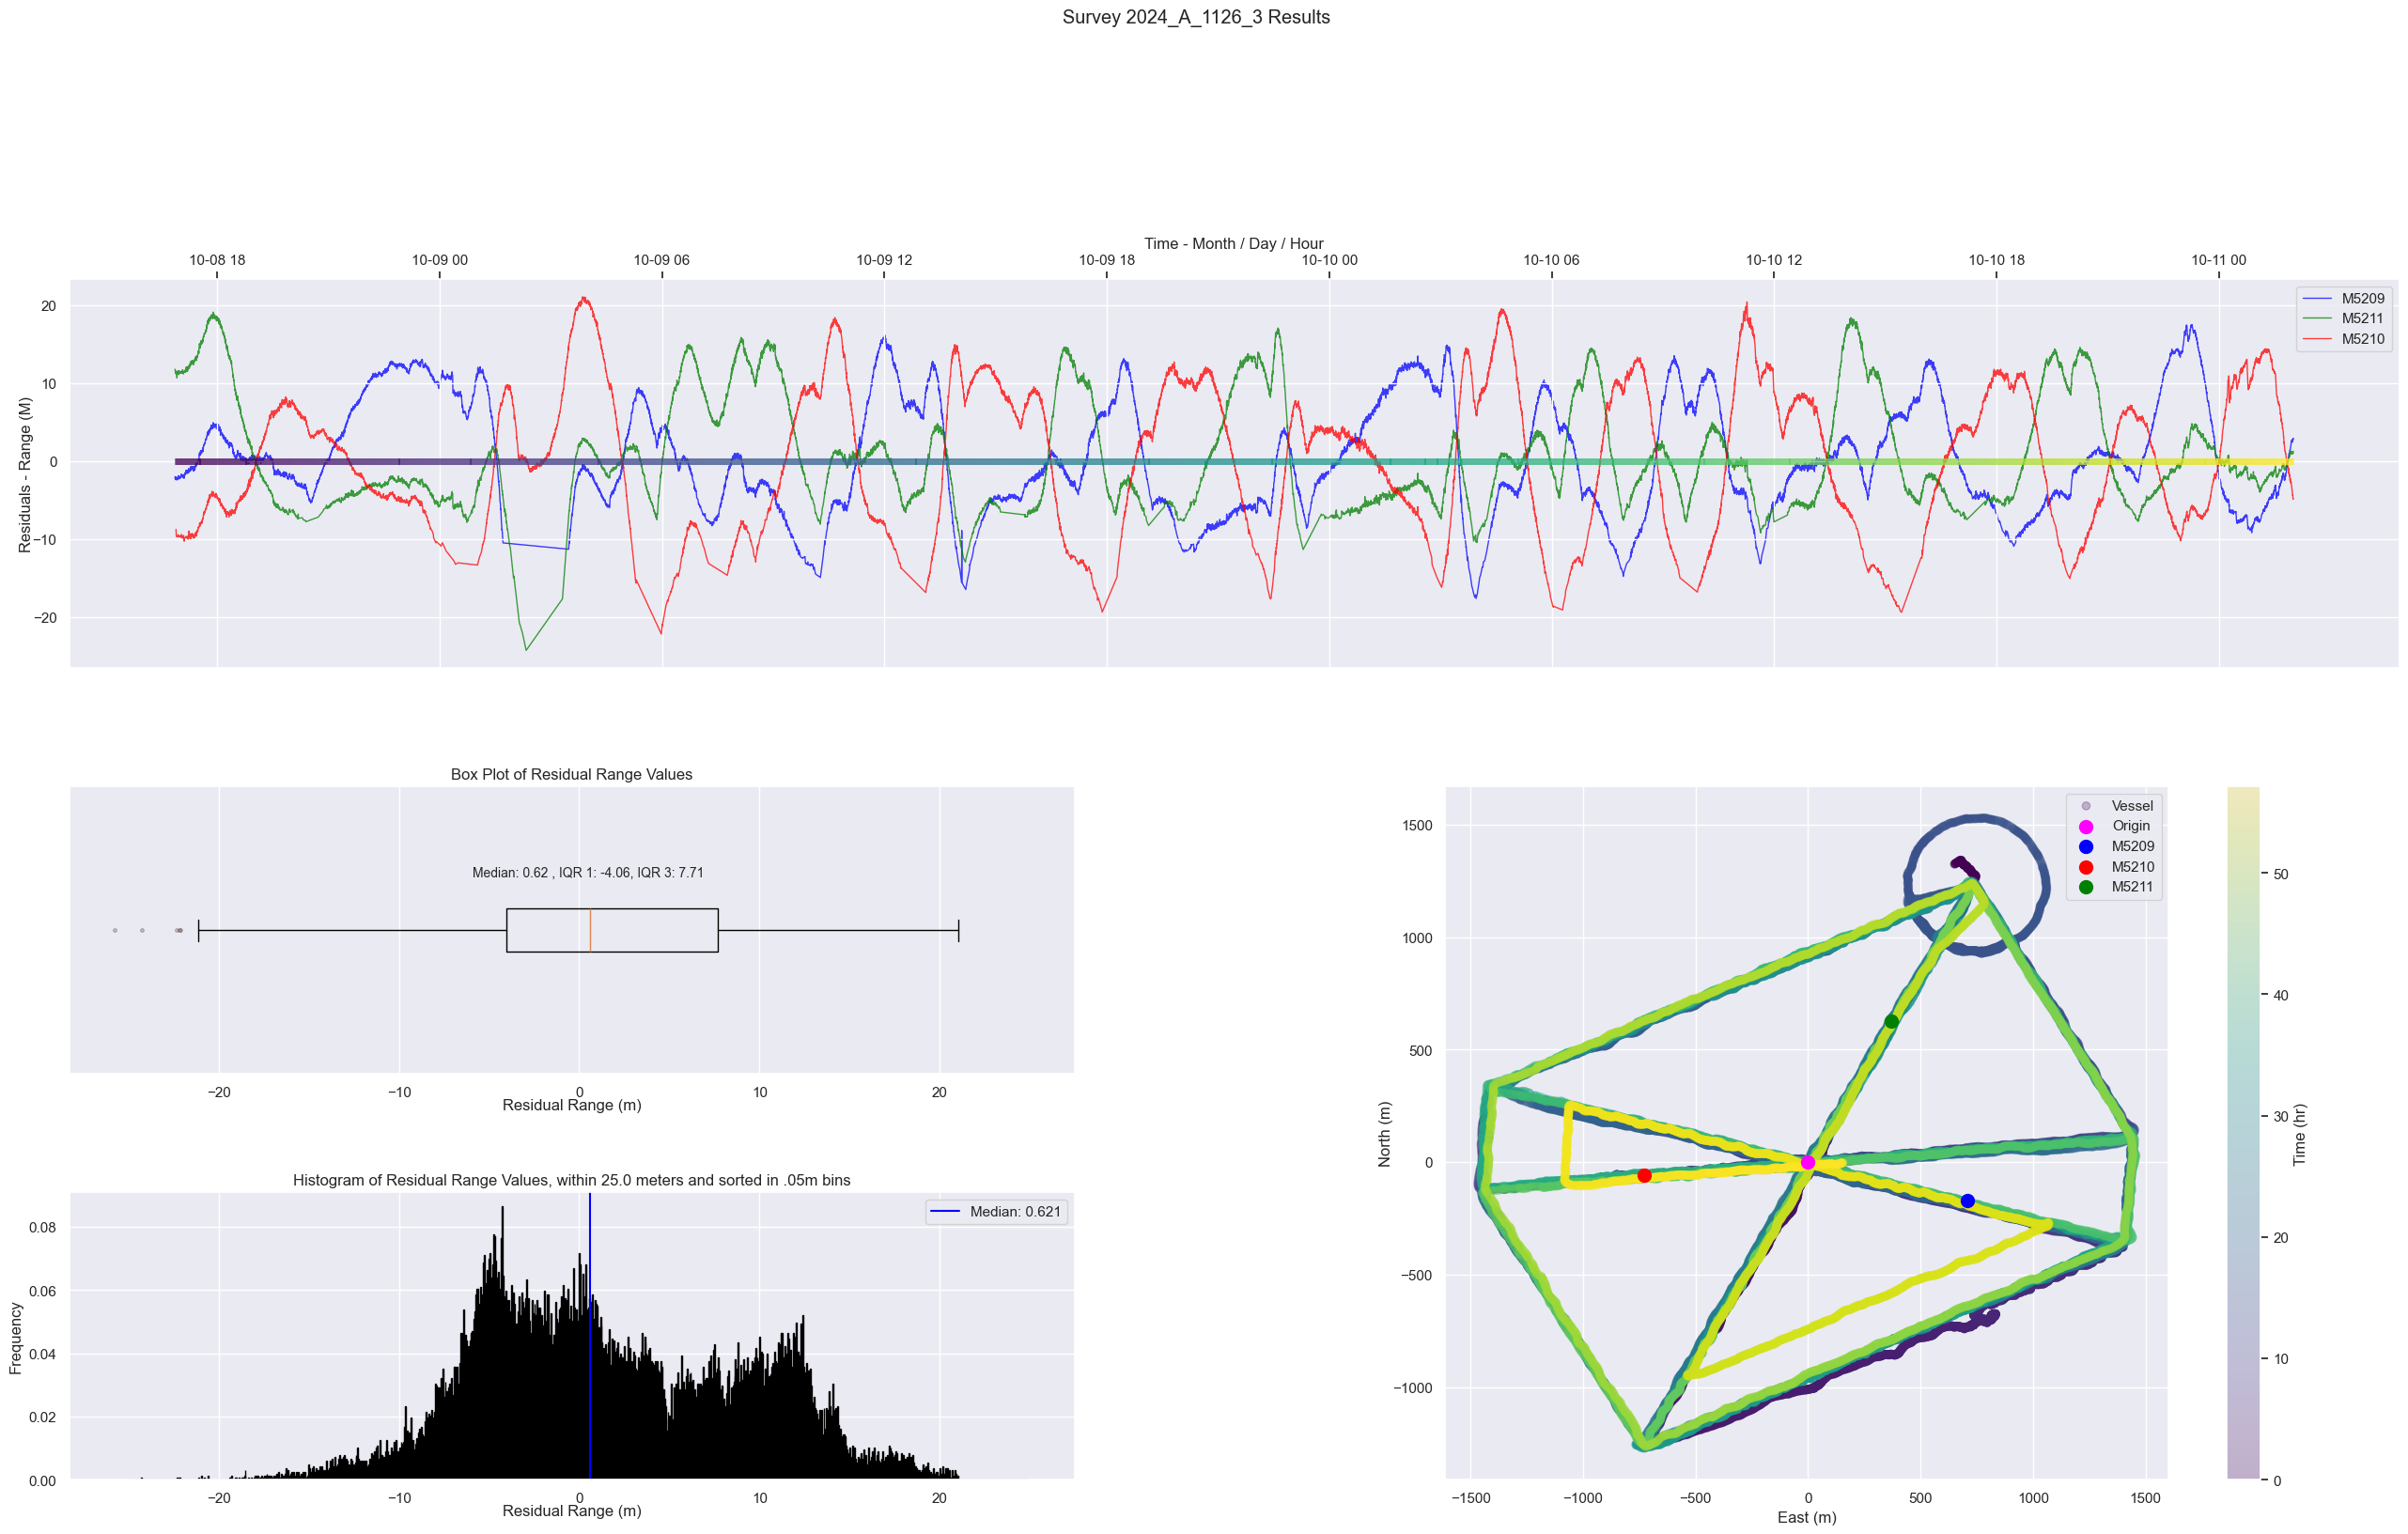

In [18]:
gp_handler_ncc1.plot_ts_results("2024_A_1126_3",res_filter=RES_FILTER)

In [19]:
gp_handler_ncc1.run_garpos(survey_id="2024_A_1126_4",override=OVERRIDE)

Results already exist for /Users/franklyndunbar/Project/SeaFloorGeodesy/Data/SFGMain/cascadia-gorda/NCC1/GARPOS/results/2024_A_1126_4/_0_results.json


Plotting results for survey  2024_A_1126_4
Delta Center Position
Array :  East 0.442 m, North 3.663 m, Up 0.000 m 
TSP M5209 : East -0.251 m, North -0.044 m, Up -0.063 m 
TSP M5210 : East -0.236 m, North -0.078 m, Up -0.106 m 
TSP M5211 : East -0.247 m, North -0.040 m, Up -0.058 m 



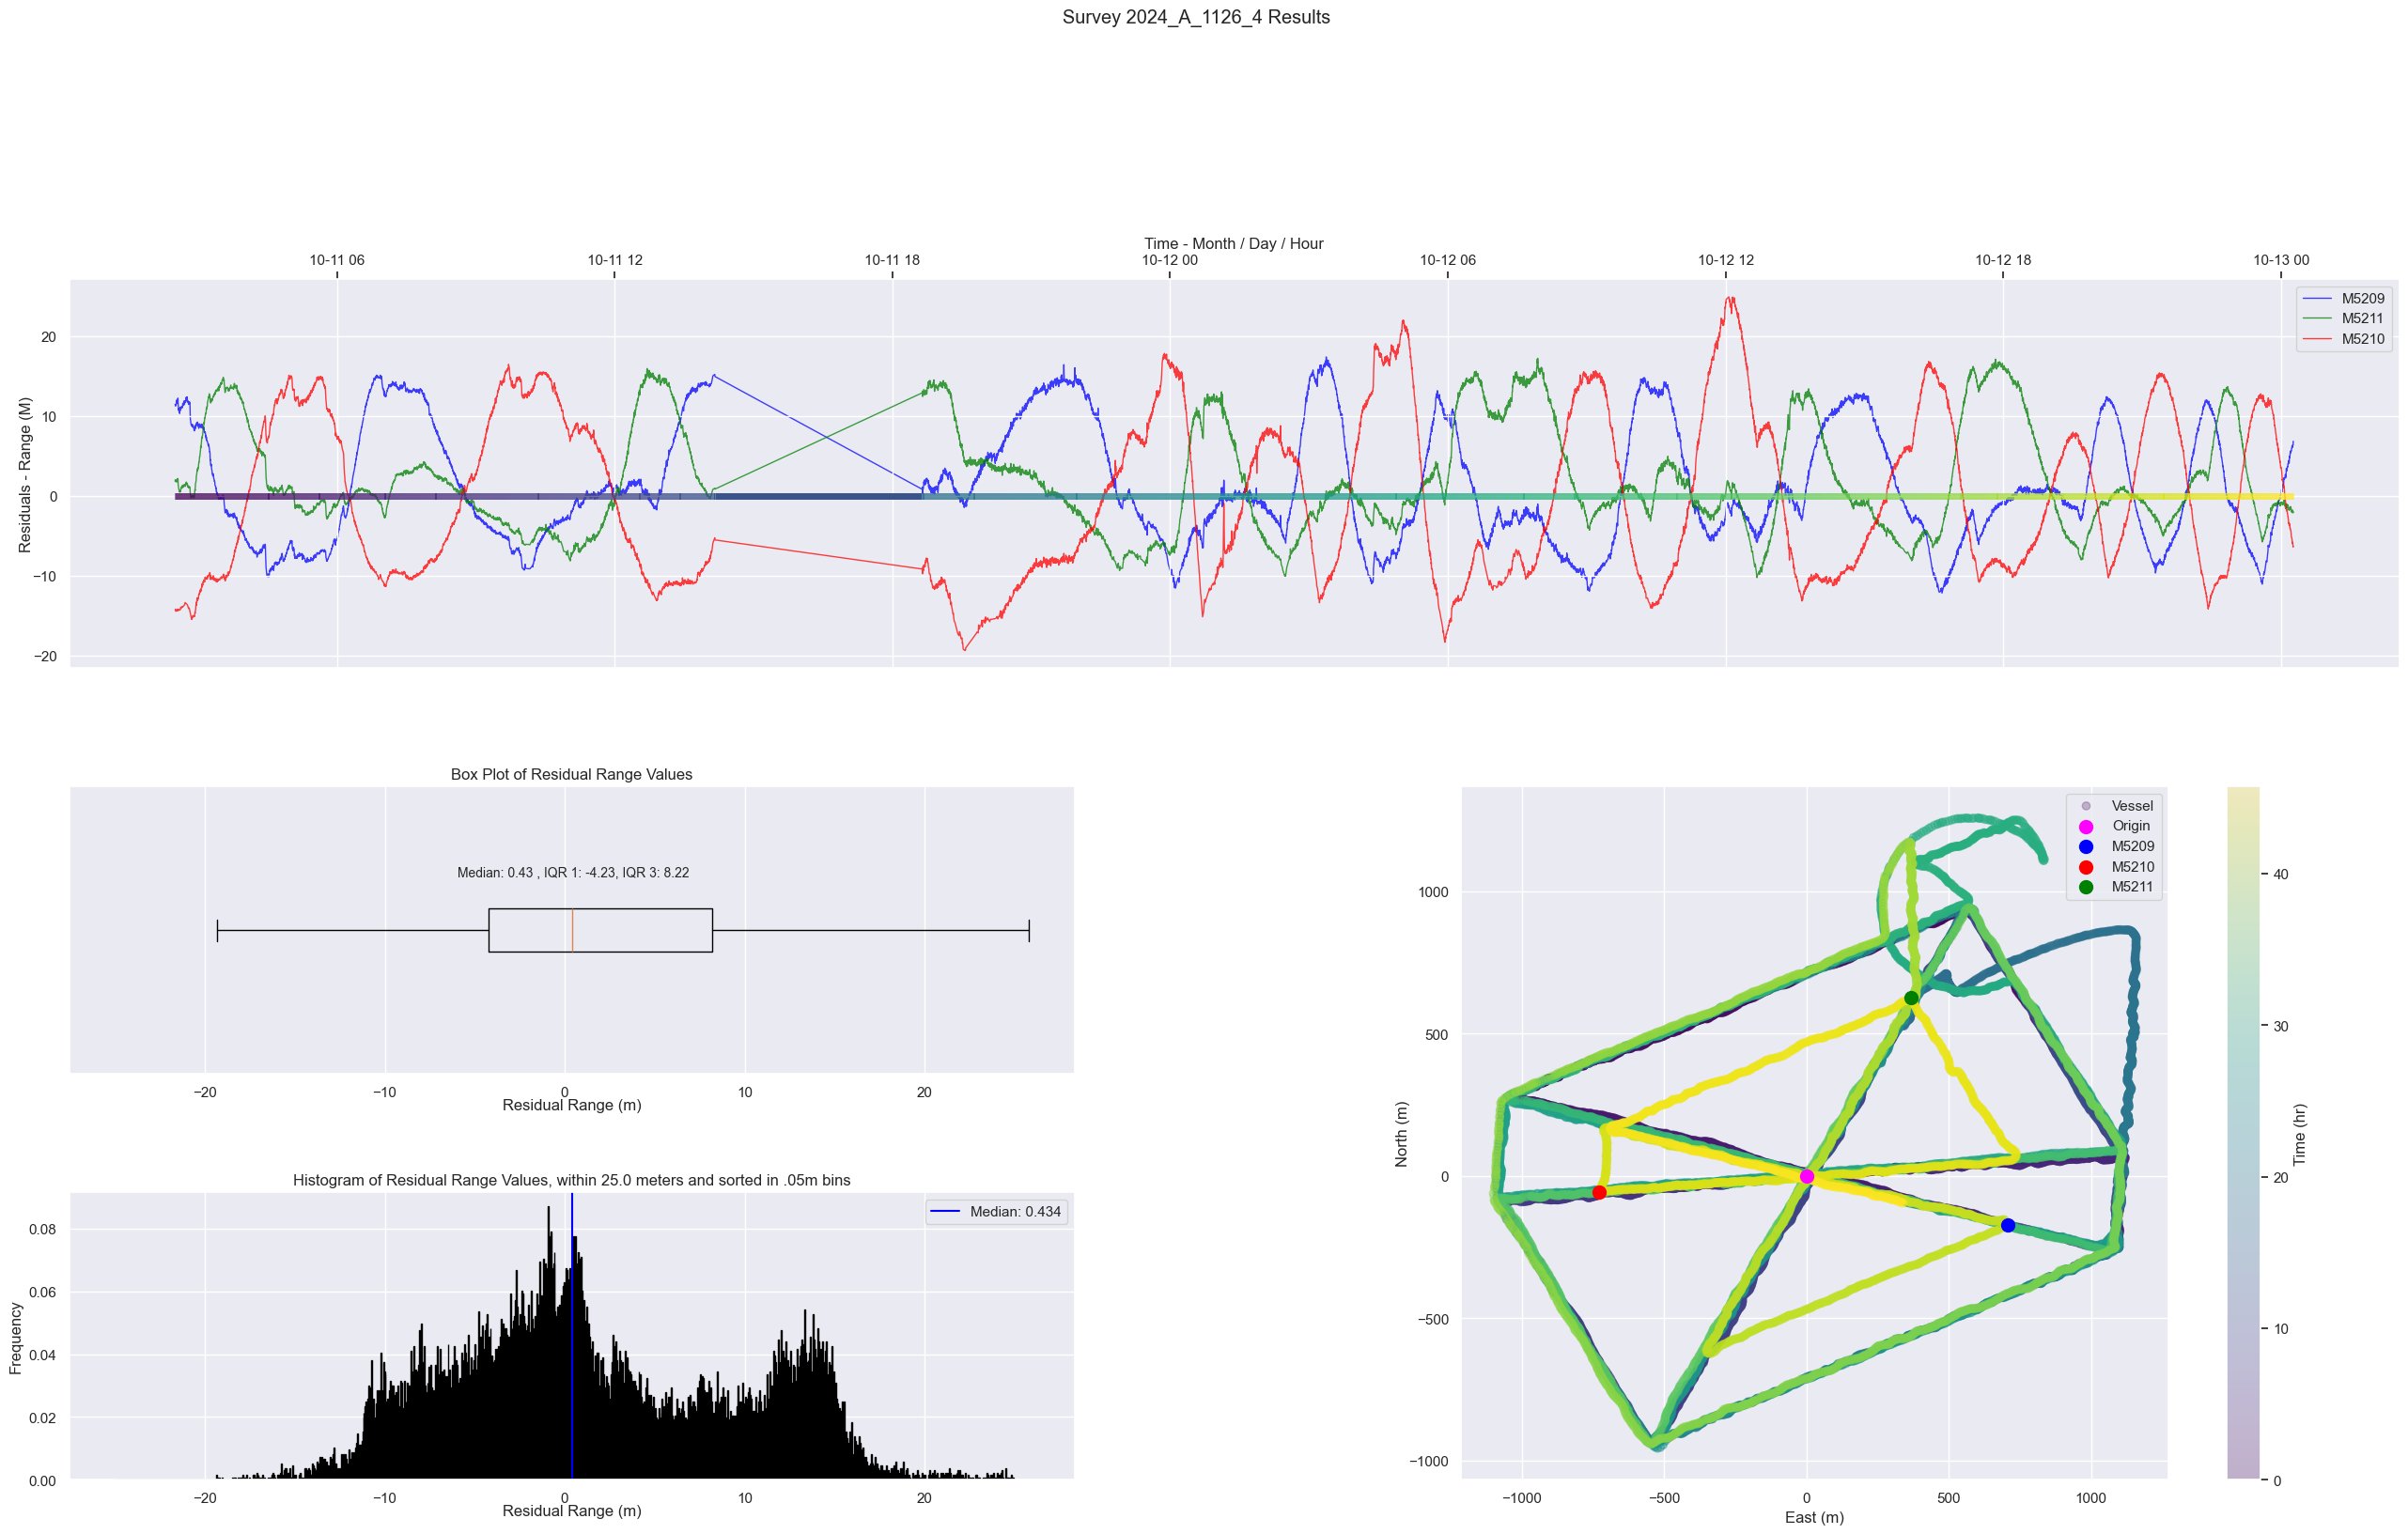

In [20]:
gp_handler_ncc1.plot_ts_results("2024_A_1126_4",res_filter=RES_FILTER)

In [21]:
gp_handler_ncc1.run_garpos(survey_id="2024_A_1126_5",override=OVERRIDE)

Results already exist for /Users/franklyndunbar/Project/SeaFloorGeodesy/Data/SFGMain/cascadia-gorda/NCC1/GARPOS/results/2024_A_1126_5/_0_results.json


Plotting results for survey  2024_A_1126_5
Delta Center Position
Array :  East 2.242 m, North 7.575 m, Up 0.000 m 
TSP M5209 : East -0.192 m, North -0.093 m, Up -0.116 m 
TSP M5210 : East -0.137 m, North -0.076 m, Up -0.113 m 
TSP M5211 : East -0.170 m, North -0.055 m, Up -0.105 m 



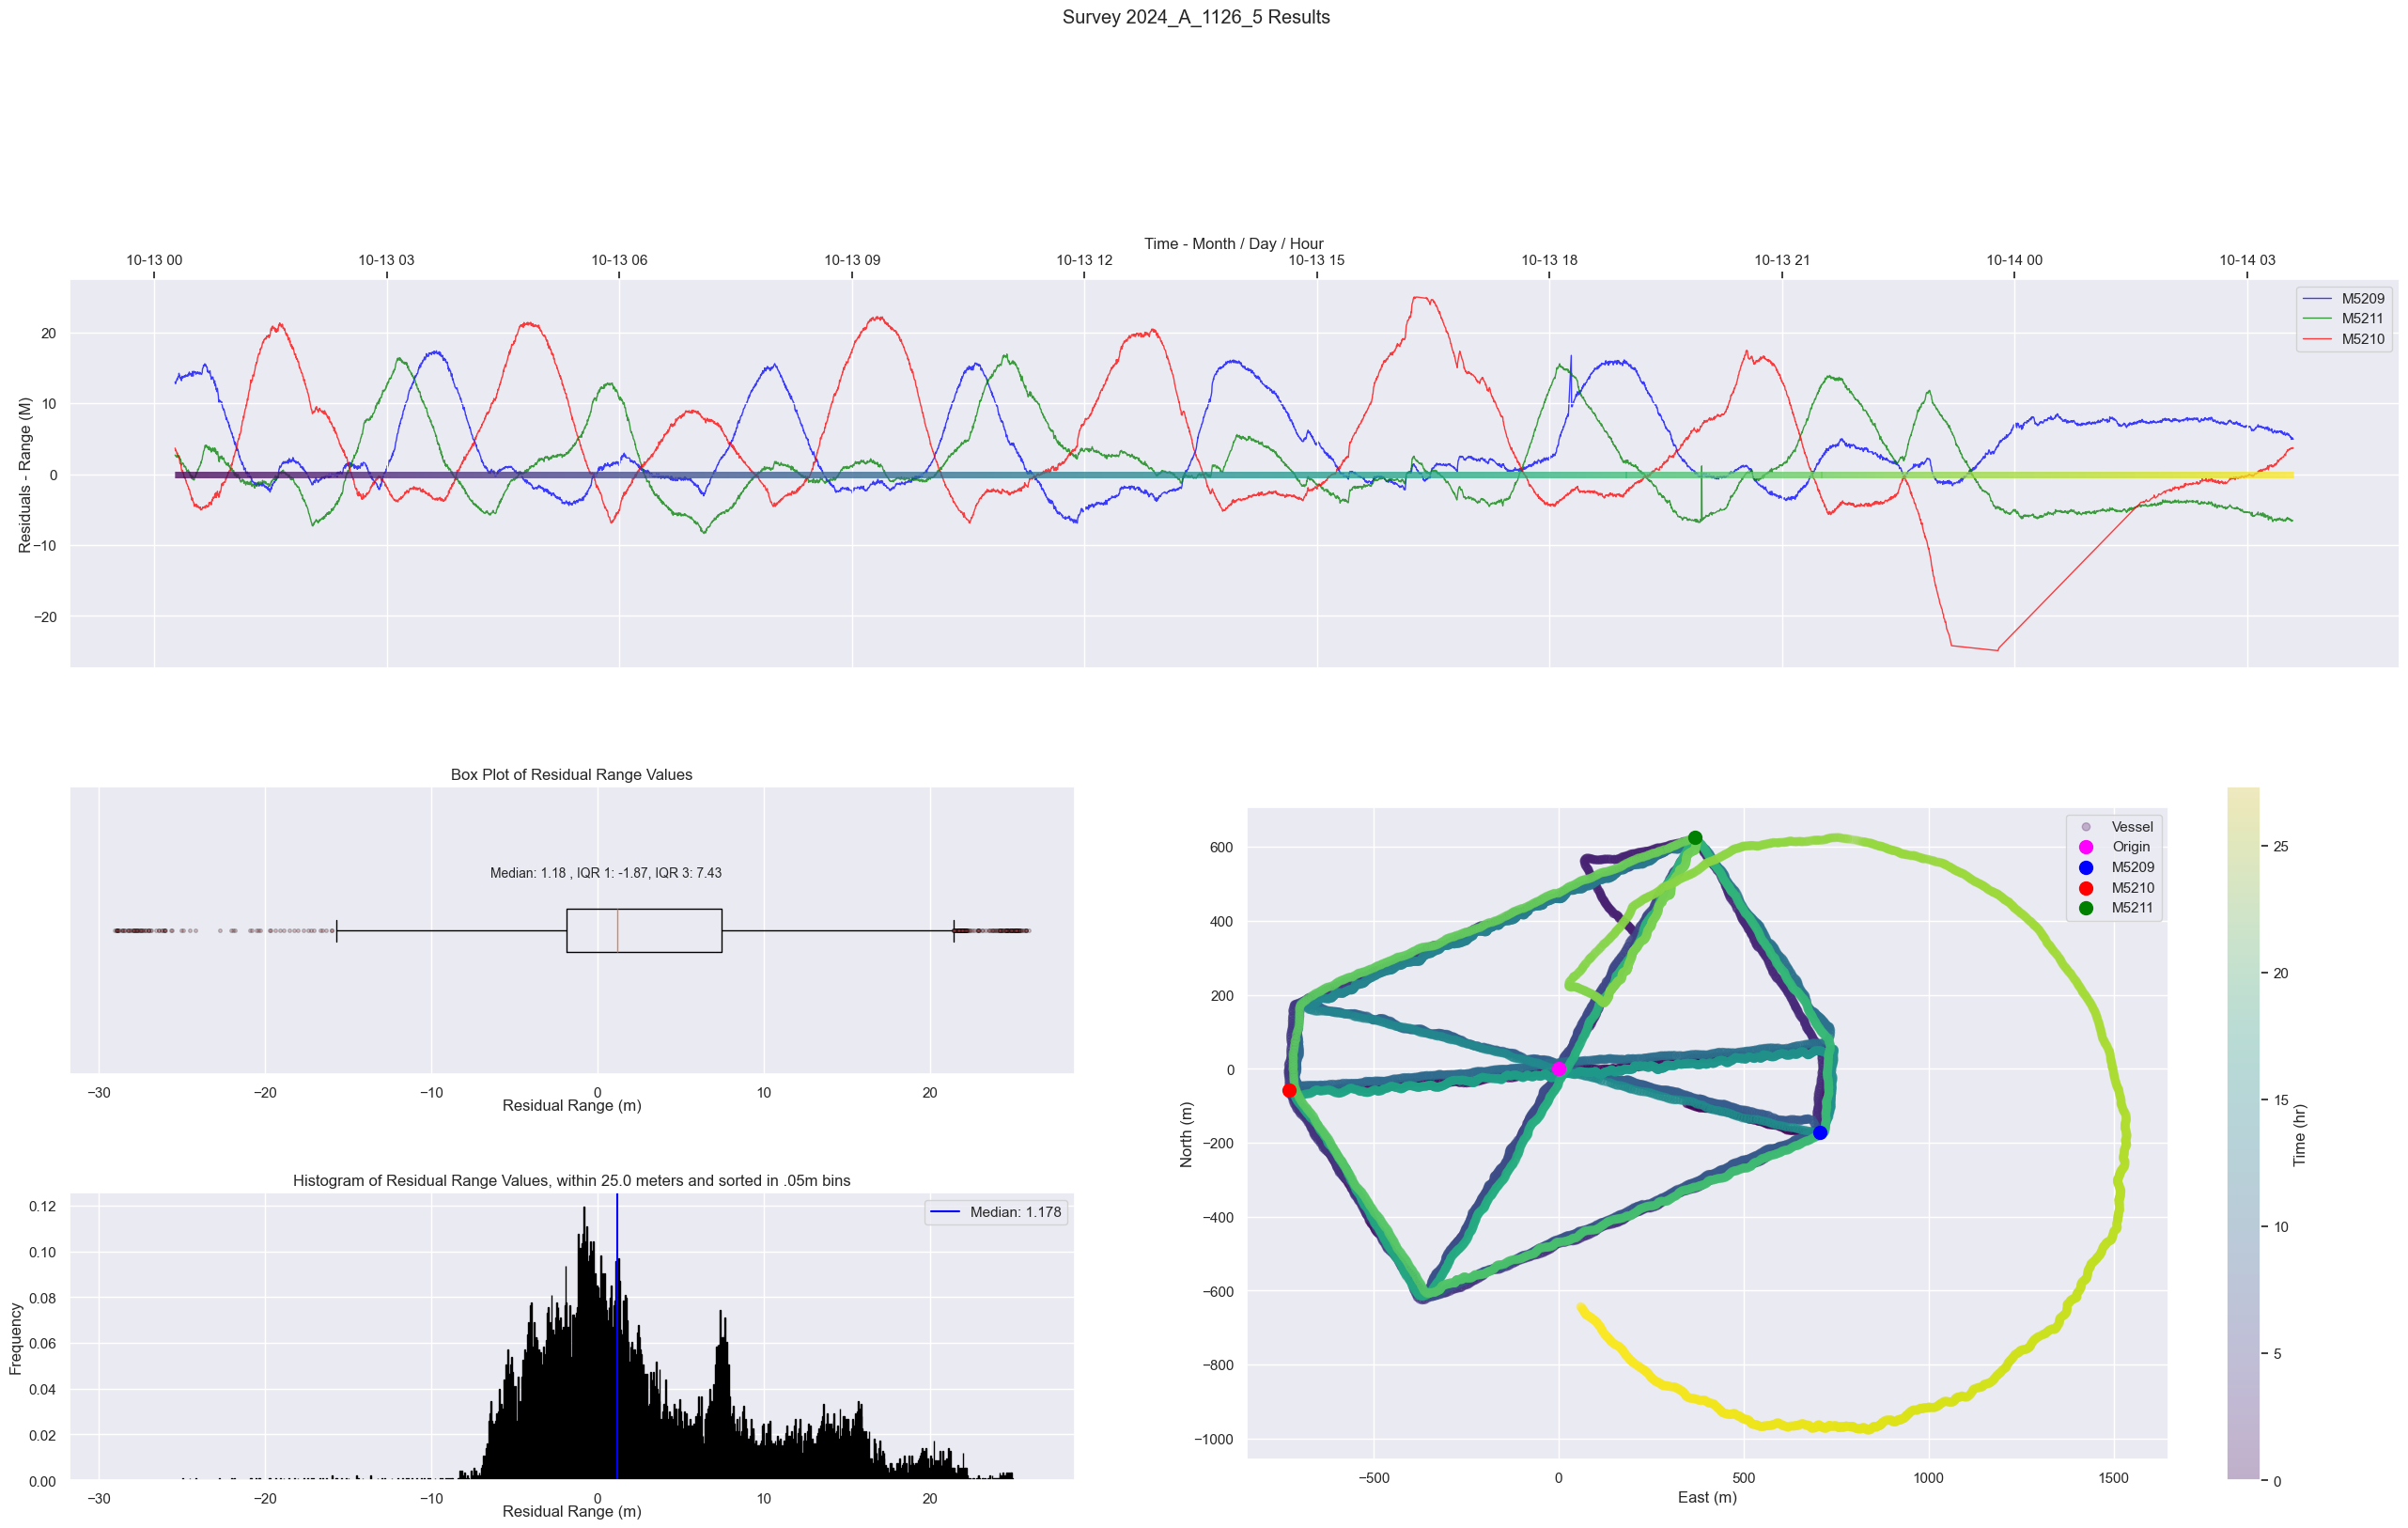

In [22]:
gp_handler_ncc1.plot_ts_results("2024_A_1126_5",res_filter=RES_FILTER)